In [1]:
#importing library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import r2_score

In [2]:
#loading the dataset
df=pd.read_csv('/kaggle/input/edmunds-car-review/Review.csv')
df

,Company,Model,Year,Reviewer,Date,Title,Rating,Review
0,acura,ilx,2013,mahowald,08/12/2012,Getting 43 Mpg on daily commute,5,"I love this car.\nGas mileage, suspension, and..."
1,acura,ilx,2013,VIP,07/26/2016,New to me ILX,5,I purchased my 2013 ILX from the dealer used w...
2,acura,ilx,2013,bybchucky,09/14/2013,Excellet Commuter Car,4,I recently purchased a 2013 ILX with the Tech ...
3,acura,ilx,2013,bayareamom,01/26/2015,Peppy Hybrid that Turns Heads,4,We bought our ILX used and have been incredibl...
4,acura,ilx,2013,Kerry Olson,03/26/2016,2013 Acura ILX Hybrid w/ Tech Package,5,In April of 2015 we were in need of another ca...
...,...,...,...,...,...,...,...,...
299040,volvo,xc70,2016,FirstVolvo,03/18/2017,Safety First,5,Except for the fact that this unit must have s...
299041,volvo,xc70,2016,Dhp,01/26/2016,Best Volvo Yet,5,Professional review was correct - crossover su...
299042,volvo,xc70,2016,Lisa B,05/03/2016,I love this car!! I own a 2006 and 16!,5,"This car is comfy, rides like a dream, has gre..."
299043,volvo,xc70,2016,Milan,05/04/2019,Couldn't resist,5,When I drove my sister's 2002 XC70 last year I...


In [3]:
#getting preliminary information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299045 entries, 0 to 299044
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Company   299045 non-null  object
 1   Model     299045 non-null  object
 2   Year      299045 non-null  int64 
 3   Reviewer  298938 non-null  object
 4   Date      299028 non-null  object
 5   Title     299010 non-null  object
 6   Rating    299045 non-null  int64 
 7   Review    299040 non-null  object
dtypes: int64(2), object(6)
memory usage: 18.3+ MB


In [4]:
def process_texts(texts):
    texts=texts.copy()
    #creating a list of most commonly used word in english
    stop_words=stopwords.words('english')
    #replacing any \ with empty and number with empty string
    texts=texts.apply(lambda x:re.sub(r'\\n','',x))
    texts=texts.apply(lambda x:re.sub(r'\d+','',x))
    #removing stop_word from the sentences
    texts=texts.apply(lambda x:" ".join([word for word in x.split() if word.lower() not in stop_words]))

    return texts


def get_sequences(texts):
    tokenizer=Tokenizer(num_words=50000)
    tokenizer.fit_on_texts(texts)
    sequences=tokenizer.texts_to_sequences(texts)
    max_sequence_length=np.max(list(map(lambda x:len(x),sequences)))
    print('The maximum sequence length',max_sequence_length)
    
    sequences=pad_sequences(sequences,maxlen=max_sequence_length,padding='post')
    return sequences


def encode_date(df,column):
    df=df.copy()
    df[column]=pd.to_datetime(df[column],errors='coerce')
    df['ReviewYear']=df[column].apply(lambda x:x.year)
    df['ReviewMonth']=df[column].apply(lambda x:x.month)
    df['ReviewDay']=df[column].apply(lambda x:x.day)
    df=df.drop(column,axis=1)
    return df



In [5]:
def onehot_encode(df,columns):
    df=df.copy()
    for column in columns:
        dummies=pd.get_dummies(df[column],prefix=column)
        df=pd.concat([df,dummies],axis=1)
        df=df.drop(column,axis=1)
        for column in df.columns:
            if df[column].dtypes=='bool':
                df[column]=df[column].astype(int)
    return df

In [ ]:
df['Date']

In [12]:
def preprocess_inputs(df):
    #creating the copy of the dataset
    df=df.copy()
    #dropping the Reviewer column 
    df=df.drop('Reviewer',axis=1)
    df=df.drop(df.loc[df['Review'].isna(),:].index,axis=0).reset_index(drop=True)
    
    df['Title']=df['Title'].fillna(df['Title'].mode()[0])

    df['Title']=process_texts(df['Title'])
    df['Review']=process_texts(df['Review'])

    title=get_sequences(df['Title'])
    reviews=get_sequences(df['Review'])

    df=df.drop(['Title','Review'],axis=1)
    
    df=onehot_encode(df,['Company','Model'])

    df=encode_date(df,'Date')
    
    
    #Filling missing value with mean of that column


    for column in ['ReviewYear','ReviewMonth','ReviewDay']:
        df[column]=df[column].fillna(df[column].mean())
    
    y=df['Rating']
    x=df.drop('Rating',axis=1)
    
    title_train,title_test,\
    reviews_train,reviews_test,\
    x_train,x_test,\
    y_train,y_test=train_test_split(title,reviews,x,y,train_size=0.7,random_state=123,shuffle=True)


    scaler=StandardScaler()
    scaler.fit(x_train)
    x_train=pd.DataFrame(scaler.transform(x_train),columns=x_train.columns,index=x_train.index)
    x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns,index=x_test.index)


    
    return title_train,title_test,reviews_train,reviews_test,x_train,x_test,y_train,y_test

In [13]:
title_train,title_test,reviews_train,reviews_test,x_train,x_test,y_train,y_test=preprocess_inputs(df)

The maximum sequence length 35
The maximum sequence length 1233


In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
y_train

In [17]:
#Constructing the Model


x_inputs=tf.keras.Input(shape=(x_train.shape[1],),name='x_inputs')
dense_1=tf.keras.layers.Dense(64,activation='relu',name='dense_1')(x_inputs)
dense_2=tf.keras.layers.Dense(64,activation='relu',name='dense_2')(dense_1)


title_inputs=tf.keras.Input(shape=(title_train.shape[1],),name='title_inputs')
title_embedding=tf.keras.layers.Embedding(input_dim=5000,output_dim=64,input_length=title_train.shape[1],name='title_embedding')(title_inputs)
title_flatten=tf.keras.layers.Flatten(name='title_flatten')(title_embedding)
reviews_inputs=tf.keras.Input(shape=(reviews_train.shape[1],),name='reviews_inputs')
reviews_embedding=tf.keras.layers.Embedding(input_dim=5000,output_dim=64,input_length=reviews_train.shape[1],name='reviews_embedding')(reviews_inputs)
reviews_flatten=tf.keras.layers.Flatten(name='reviews_flatten')(reviews_embedding)

concat=tf.keras.layers.concatenate([dense_2,title_flatten,reviews_flatten],name='concatenation')
outputs=tf.keras.layers.Dense(1,activation='linear')(concat)

model=tf.keras.Model(inputs=[x_inputs,title_inputs,reviews_inputs],outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_inputs            │ (None, 947)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_inputs        │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reviews_inputs      │ (None, 1233)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     60,672 │ x_inputs[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_embedding     │ (None, 35, 64)    │    320,000 │ title_inputs[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reviews_embedding   │ (None, 1233, 64)  │    320,000 │ reviews_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_flatten       │ (None, 2240)      │          0 │ title_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reviews_flatten     │ (None, 78912)     │          0 │ reviews_embeddin… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenation       │ (None, 81216)     │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ title_flatten[0]… │
│                     │                   │            │ reviews_flatten[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │     81,217 │ concatenation[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 786,049 (3.00 MB)

 Trainable params: 786,049 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

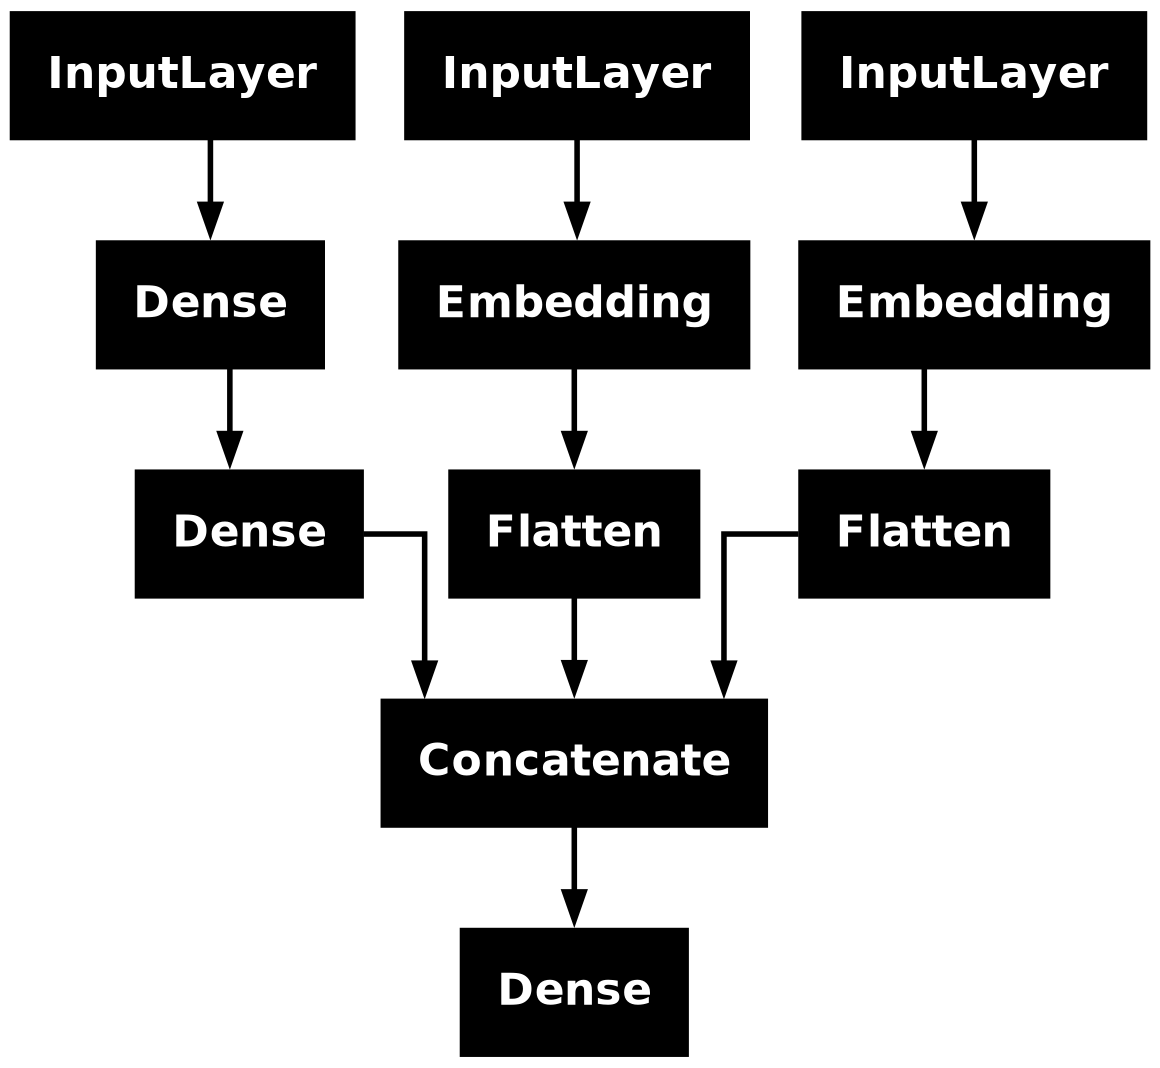

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
model.compile(optimizer='adam',loss='mse')
history=model.fit([x_train,title_train,reviews_train],y_train,validation_split=0.2,batch_size=32,epochs=10,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)])

Epoch 1/10


I0000 00:00:1733823076.530642     186 service.cc:145] XLA service 0x7ca814003a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733823076.530699     186 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  27/5234 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 5.1757

I0000 00:00:1733823077.551285     186 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5234/5234 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 0.6869 - val_loss: 0.5494
Epoch 2/10
5234/5234 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.4177 - val_loss: 0.5314
Epoch 3/10
5234/5234 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 0.3999 - val_loss: 0.5786
Epoch 4/10
5234/5234 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 0.4016 - val_loss: 0.5820
Epoch 5/10
5234/5234 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.3567 - val_loss: 0.6335
Epoch 6/10
5234/5234 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.3328 - val_loss: 0.6562
Epoch 7/10
5234/5234 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.3454 - val_loss: 0.6900


In [21]:
#Constructing the Model
model.evaluate([x_test,title_test,reviews_test],y_test)

2804/2804 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5271


0.5334844589233398

In [25]:
r2=r2_score(y_test,model.predict([x_test,title_test,reviews_test],verbose=0))
print('The r2 score for the model',r2)

The r2 score for the model 0.4597668149322288


In [ ]:
x.isna().sum().sum()

In [ ]:
title

In [ ]:
review